In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
from tqdm import tqdm 
%matplotlib notebook

# Intraorbital SC
We start considering only the intraorbital SC order parameter in the HF Hamiltonian, so we study
\begin{equation}
H =
\end{equation}

# Parameters definition

In [2]:
t1 = 1.0
t2 = 1.0

def Ek(t, k):
    E = -2*t*(np.cos(k[0]) + np.cos([k[1]]))
    return E

def lamb_intra(Ek, U, Del):
    l = np.sqrt( np.square( Ek ) + np.square(U*Del) )
    return l

def lamb_inter(Ek, U, J, Del):
    l = np.sqrt( np.square( Ek ) + np.square((U - 2*J)*Del) )
    return l

In [3]:
""" How many k points in the BZ """

grid_kx = np.linspace(-np.pi, np.pi, 100, endpoint = False)
grid_ky = np.linspace(-np.pi, np.pi, 100, endpoint = False)
grid_Ek = np.zeros((len(grid_kx), len(grid_ky)))

for (i, kx) in enumerate(grid_kx): 
    for (j, ky) in enumerate(grid_ky):
        k = np.array([kx, ky])
        grid_Ek[i][j] = Ek(t1, k)

In [31]:
U_array = np.r_[ -20 : -0.000001 : 200j ]

Del_intra_array = np.zeros(len(U_array))
guess = 0.5
#print(Del_array)
for l in tqdm(range(len(U_array))):
    U = U_array[l]
    for m in range(100):
        Del = 0.0
        for (i, kx) in enumerate(grid_kx): 
               for (j, ky) in enumerate(grid_ky):
                Del += 1.0/lamb_intra(grid_Ek[i][j], U, guess) 
        Del = -0.5*Del*U/np.square(len(grid_kx))*guess
        if(abs(Del - guess) < 1.0E-4):
            energy_Del = 0.0
            energy_Del0 = 0.0
            for (i, kx) in enumerate(grid_kx): 
                for (j, ky) in enumerate(grid_ky):
                    energy_Del += -lamb_intra(grid_Ek[i][j], U, Del) 
                    energy_Del0 += -lamb_intra(grid_Ek[i][j], U, 0) 
                    
            energy_Del = energy_Del/np.square(len(grid_kx)) - U*Del**2.0
            energy_Del0 = energy_Del0/np.square(len(grid_kx))
            if(energy_Del < energy_Del0):
                Del_intra_array[l] = Del
            else:
                Del_intra_array[l] = 0.0
            break
        guess = guess*0.5 + Del*0.5
#print(Del_array)



100%|█████████████████████████████████████████| 200/200 [02:13<00:00,  1.50it/s]


In [32]:
with open('results/intra_orbital_SC.dat', 'w') as data:
    data.write("#U  Del")
    for l in range(len(U_array)):
        U = U_array[l]
        data.write("\n{0:5.4f}  {1:5.4f}".format(U, Del_intra_array[l]))

In [2]:
fname = "results/intra_orbital_SC.dat"
data = np.loadtxt(fname)
U_array = data[:,0]
Del_intra_array = data[:,1]

<IPython.core.display.Javascript object>


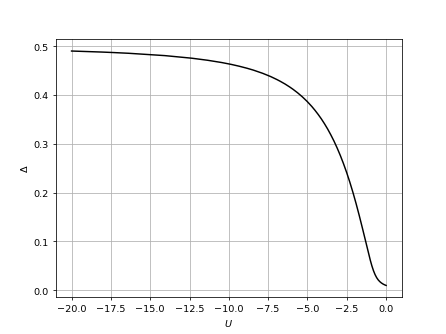

In [3]:
"""Plot of the order parameter"""
plt.figure()

plt.title(r'')
plt.grid()
#plt.xlim([-20,3])
plt.xlabel(r'$U$')
plt.ylabel(r'$\Delta$')
plt.plot(U_array, Del_intra_array, '-', color = 'black')
#plt.show()
plt.savefig('results/intra_orbital_SC.png')

# Inter-orbital SC

In [35]:
U_array = np.r_[ -10 : -0.1 : 20j ]
J_array = np.r_[ -10.1 : 10.1 : 20j ]

Del_inter_array = np.zeros([len(U_array),len(J_array)])
guess = 0.5
for l in tqdm(range(len(U_array))):
    U = U_array[l]
    for s in range(len(J_array)):
        J = J_array[s]
        for m in range(100):
            Del = 0.0
            for (i, kx) in enumerate(grid_kx): 
                for (j, ky) in enumerate(grid_ky):
                    Del += 1.0/lamb_inter(grid_Ek[i][j], U, J, guess) 
            Del = -0.5*Del*(U-2*J)/np.square(len(grid_kx))*guess
            if (Del < 0.0):
                guess = -Del
                continue
            elif(abs(Del - guess) < 1.0E-4):
                energy_Del = 0.0
                energy_Del0 = 0.0
                for (i, kx) in enumerate(grid_kx): 
                    for (j, ky) in enumerate(grid_ky):
                        energy_Del += -lamb_inter(grid_Ek[i][j], U, J, Del) 
                        energy_Del0 += -lamb_inter(grid_Ek[i][j], U, J, 0) 
                        
                energy_Del = energy_Del/np.square(len(grid_kx)) - (U-2*J)*Del**2.0
                energy_Del0 = energy_Del0/np.square(len(grid_kx))
                if(energy_Del < energy_Del0):
                    Del_inter_array[l][s] = Del
                else:
                    Del_inter_array[l][s] = 0.0
                break
            guess = guess*0.5 + Del*0.5
#print(Del_inter_array)


  0%|                                                    | 0/20 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [46]:
""" Save data """
with open('results/inter_orbital_SC.dat', 'w') as data:
    data.write("#U  J  Del")
    for l in range(len(U_array)):
        U = U_array[l]
        for s in range(len(J_array)):
            J = J_array[s]
            data.write("\n{0:5.4f}  {1:5.4f}  {2:5.4f}".format(U, J, Del_inter_array[l][s]))
    

In [4]:
""" Import data """
fname = "results/inter_orbital_SC.dat"
data = np.loadtxt(fname)
U_array = np.r_[ -10 : -0.1 : 20j ]
J_array = np.r_[ -10.1 : 10.1 : 20j ]
Del_inter_array = np.zeros([len(U_array),len(J_array)])

for l in range(len(U_array)):
    for s in range(len(J_array)):
        Del_inter_array[l][s] = data[l*len(U_array) + s ,2]

<IPython.core.display.Javascript object>


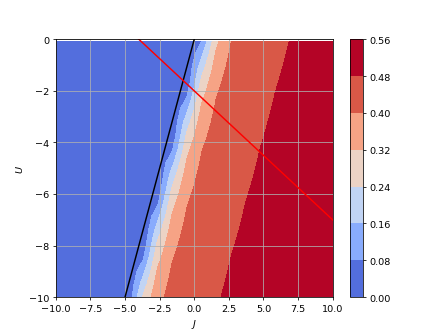

In [5]:
"""Plot of the order parameter"""
cmaps = ['viridis', 'coolwarm']
U_array = np.r_[ -10 : -0.1 : 20j ]
J_array = np.r_[ -10.1 : 10.1 : 20j ]

plt.figure()

vmin_Del, vmax_Del = np.min(Del_inter_array), np.max(Del_inter_array)
#plt.pcolormesh(J_array, U_array, Del_array , cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del)
plt.contourf(J_array, U_array, Del_inter_array, cmap=cmaps[1], vmin=vmin_Del, vmax=vmax_Del)
plt.colorbar()
plt.title(r'')
plt.grid()
plt.xlim([-10,10])
plt.ylim([-10,0])
plt.xlabel(r'$J$')
plt.ylabel(r'$U$')
y = 2*J_array
z = -1/2*J_array - 2
plt.plot(J_array, y, '-', color = 'black')
plt.plot(J_array, z, '-', color = 'red')
#plt.show()
plt.savefig('results/inter_orbital_SC.png')

In [27]:

J_array = np.r_[ -1.5 : 10.1 : 200j ]

Del_inter_sec_array = np.zeros(len(J_array))
guess = 0.5
for s in tqdm(range(len(J_array))):
    J = J_array[s]
    U = -1/2*J - 2
    for m in range(100):
        Del = 0.0
        for (i, kx) in enumerate(grid_kx): 
            for (j, ky) in enumerate(grid_ky):
                Del += 1.0/lamb_inter(grid_Ek[i][j], U, J, guess) 
        Del = -0.5*Del*(U-2*J)/np.square(len(grid_kx))*guess
        if (Del < 0.0):
            guess = -Del
            continue
        elif(abs(Del - guess) < 1.0E-4):
            energy_Del = 0.0
            energy_Del0 = 0.0
            for (i, kx) in enumerate(grid_kx): 
                for (j, ky) in enumerate(grid_ky):
                    energy_Del += -lamb_inter(grid_Ek[i][j], U, J, Del) 
                    energy_Del0 += -lamb_inter(grid_Ek[i][j], U, J, 0) 

            energy_Del = energy_Del/np.square(len(grid_kx)) - (U-2*J)*Del**2.0
            energy_Del0 = energy_Del0/np.square(len(grid_kx))
            if(energy_Del < energy_Del0):
                Del_inter_sec_array[s] = Del
            else:
                Del_inter_sec_array[s] = 0.0
            break
        guess = guess*0.5 + Del*0.5

100%|█████████████████████████████████████████| 200/200 [03:46<00:00,  1.13s/it]


In [28]:
with open('results/inter_orbital_sec_SC.dat', 'w') as data:
    data.write("#U = -0.5*J - 2.0")
    data.write("#J  Del")
    for l in range(len(J_array)):
        J = J_array[l]
        data.write("\n{0:5.4f}  {1:5.4f}".format(J, Del_inter_sec_array[l]))

In [2]:
fname = "results/inter_orbital_sec_SC.dat"
data = np.loadtxt(fname)
J_array = data[:,0]
Del_inter_sec_array = data[:,1]

<IPython.core.display.Javascript object>


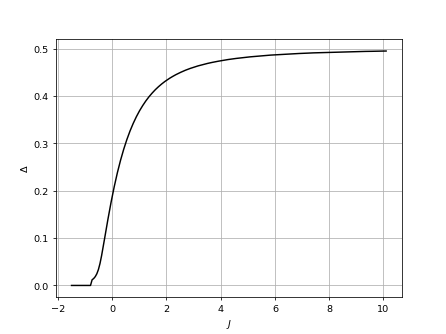

In [3]:
"""Plot of the order parameter"""
plt.figure()

plt.title(r'')
plt.grid()
#plt.xlim([-20,3])
plt.xlabel(r'$J$')
plt.ylabel(r'$\Delta$')
plt.plot(J_array, Del_inter_sec_array, '-', color = 'black')
plt.show()
plt.savefig('results/intra_orbital_SC.png')